In [6]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from tqdm import tqdm
import json

In [15]:
# Load data extracted_fls_metrics.json
with open('../datasets/EXTRACTED_FLS_METRICS.json', 'r') as json_file:
    data = json.load(json_file)
df = pd.DataFrame(data)

df_fls = df[df['FLS']=='FLS']
df_fls.drop(columns=['FLS'], inplace=True)
df_fls.reset_index(inplace=True)
df_fls.head()

,index,Sentence,Metric,Item,Year,CIK,Company
0,9,We intend to retain earnings to finance the ex...,Net Income,item_1A,2015,1000228,HENRY SCHEIN INC
1,20,We intend to retain earnings to finance the ex...,Net Income,item_1A,2016,1000228,HENRY SCHEIN INC
2,33,We intend to retain earnings to finance the ex...,Net Income,item_1A,2018,1000228,HENRY SCHEIN INC
3,35,(3) In 2017 there was an estimated one-time-ch...,Net Income,item_1A,2018,1000228,HENRY SCHEIN INC
4,68,We intend to retain earnings to finance the ex...,Net Income,item_1A,2019,1000228,HENRY SCHEIN INC


In [39]:
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from tqdm import tqdm

def classify_and_save_batch(df, model_name, output_filename, max_sequence_length=512, batch_size=8):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    nlp = pipeline("text-classification", model=model, tokenizer=tokenizer, device=0, truncation=True,max_length=max_sequence_length)  # Set device to use GPU
    
    # Create a label mapping dictionary
    if model_name == '../model/distilbert-fls':
        label_mapping = {'LABEL_1': 'FLS', 'LABEL_0': 'Not FLS'}
    elif model_name == 'yiyanghkust/finbert-fls':
        label_mapping = {'Specific FLS': 'FLS', 
                         'Non-specific FLS': 'Not FLS',
                         'Not FLS': 'Not FLS'}

    # Create a new column for labels in the DataFrame
    df['Label'] = ""

    # Iterate through the DataFrame and classify each sentence in batches with a progress bar
    sentences = df['Sentence'].tolist()
    num_sentences = len(sentences)

    with tqdm(total=num_sentences, desc=f"Processing {model_name}") as pbar:
        for start in range(0, num_sentences, batch_size):
            batch_sentences = sentences[start : start + batch_size]
            batch_results = nlp(batch_sentences)
            

            for i, result in enumerate(batch_results):
                label = result['label']  # Access the label from the first dictionary in the list
                
                # Use the label mapping dictionary to convert the label to the desired format
                mapped_label = label_mapping[label]
                
                # Update the original DataFrame with the mapped label
                original_index = start + i
                df.at[original_index, 'Label'] = mapped_label
                pbar.update(1)
                
    # Save the resulting DataFrame to a CSV file
    df.to_csv(output_filename, index=False)


In [40]:
classify_and_save_batch(df_fls, 'yiyanghkust/finbert-fls', '../datasets/finbert_dataset.csv', max_sequence_length=512, batch_size=32)

<ipython-input-39-830d0a6736ef>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = ""
Processing yiyanghkust/finbert-fls:   1%|          | 289/34729 [00:02<04:07, 139.42it/s]/home/nguyenk/.local/lib/python3.8/site-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
Processing yiyanghkust/finbert-fls: 100%|██████████| 34729/34729 [04:00<00:00, 144.43it/s]


In [36]:
classify_and_save_batch(df_fls, '../model/distilbert-fls', '../datasets/distilbert_dataset.csv', max_sequence_length=512, batch_size=32)

<ipython-input-34-1fda8f820b8f>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Label'] = ""
Processing ../model/distilbert-fls: 100%|██████████| 34729/34729 [02:25<00:00, 238.09it/s]


In [37]:
# load the dataset
df_distilbert = pd.read_csv('../datasets/distilbert_dataset.csv')
df_distilbert.Label.value_counts()


FLS        33632
Not FLS     1097
Name: Label, dtype: int64

In [41]:
# load the dataset
df_finbert = pd.read_csv('../datasets/finbert_dataset.csv')
df_finbert.Label.value_counts()

Not FLS    29504
FLS         5225
Name: Label, dtype: int64

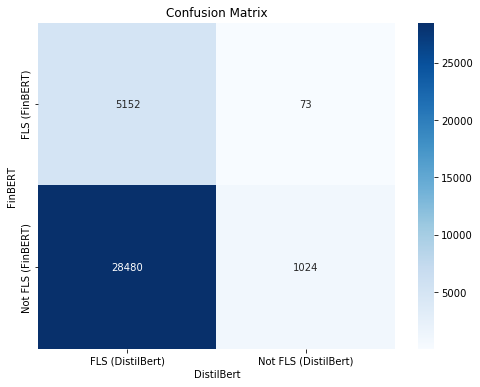

In [54]:

# Create a confusion matrix to compare the differences between the two models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# Create a confusion matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(df_finbert['Label'], df_distilbert['Label']), 
                                    index=['FLS (FinBERT)', 'Not FLS (FinBERT)'], 
                                    columns=['FLS (DistilBert)', 'Not FLS (DistilBert)'])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, annot=True, cmap='Blues', fmt='g')
plt.title(f'Confusion Matrix')
plt.ylabel('FinBERT')
plt.xlabel('DistilBert')
plt.show()

In [55]:
confusion_matrix_df

,FLS (DistilBert),Not FLS (DistilBert)
FLS (FinBERT),5152,73
Not FLS (FinBERT),28480,1024


In [ ]:
# Error analysis
# Examine the instances where the models disagreed (e.g., one model predicted 'FLS' while the other predicted 'Not FLS'). 
# Analyze the text and context of these instances to understand why there are differences.